In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy.interpolate import interp1d

from SiPM import SiPMClass
from WaveformGenerator import WaveformClass
from NSB import NSBClass
from Shower import ShowerClass
import ROOT as root
import pickle

created SiPM class
created NSB class
created shower class
created waveform class
Welcome to JupyROOT 6.16/00


### Define Shower: 

In [2]:
my_shower = ShowerClass(shower_wavelength = 400, shower_intensity = 10, time_position = 850e-9, 
                        time_distribution_data = 'time_distribution.txt', pe = False)

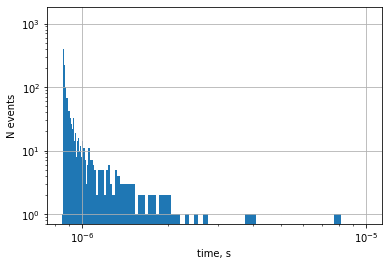

In [3]:
my_shower.build_time_distribution_hist(10000)
plt.xlabel("time, s")
plt.ylabel("N events")
plt.savefig('time_dist.png')

### Define SiPM: 

In [10]:
pde_data = './SiPM/FbK_NUV-HD_3x3_40um_epoxy_relative.txt'

size_mm = 3
upixel_size_mm = 0.035
n_pixels = int(pow(size_mm/upixel_size_mm, 2))
print('N pixels : ',n_pixels)

p_xt = 0.10
dcr_mm = 10e3
dcr = size_mm*size_mm*dcr_mm
std_el = 0.1
pde = 0.52
wavelength = 420
slow_tau = 40e-9

my_sipm = SiPMClass('test', pde = pde_data, npixels = n_pixels, std_el = std_el, std_gain = 0.09, 
                    p_xt = p_xt, dcr = dcr, pde_norm_factor = pde, 
                    pde_norm_wavelength = wavelength, norm_pde = True)

my_sipm.generate_template(3e-9, 2e-9, slow_tau, sampling=0.2e-9, length=1e-6)
my_sipm.describe()

N pixels :  7346
SiPM :: Template was created
SiPM name :  test
PDE 0.52 @ 420 nm
DCR 0.09 MHz
Pxt  0.1
STD electronics:  0.1
STD Gain:  0.09


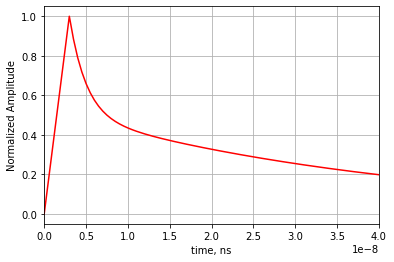

No handles with labels found to put in legend.


Text(0.5, 1.0, 'FBK, NUV-HD. w/o coating')

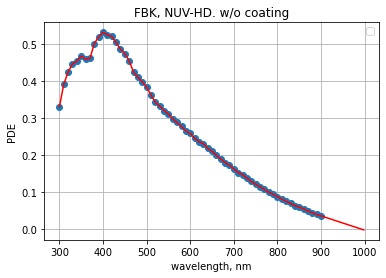

In [11]:

x_time = np.arange(0, 200e-9, 0.5e-9)
plt.plot(x_time, my_sipm.template['f1d'](x_time), 'r-')
plt.grid()
plt.xlabel("time, ns")
plt.ylabel("Normalized Amplitude")
plt.xlim(0, 40e-9)
plt.show()

plt.plot(my_sipm.pde['wavelength'], my_sipm.pde['pde'], 'o')
x_wl = np.arange(300, 1000, 2)
plt.plot(x_wl, my_sipm.pde['f1d'](x_wl), '-r')
plt.grid()
plt.ylabel('PDE')
plt.xlabel('wavelength, nm')
plt.legend()
plt.title('FBK, NUV-HD. w/o coating')

In [37]:
my_sipm.describe()

SiPM name :  test
PDE 0.52 @ 420 nm
DCR 0.09 MHz
Pxt  0.1
STD electronics:  0.1
STD Gain:  0.09


In [38]:
data_template = np.loadtxt('/home/andrii/work/data/SiPM_3075CN/LCT5_NUV_Template_Miteq.txt', dtype=float, comments='#', delimiter=', ')

In [39]:
data_template[:,0]

array([ 6.10705596,  8.20559611, 10.15206813, 12.18978102, 14.10583942,
       16.23479319, 18.18126521, 20.2189781 , 22.16545012, 24.17274939,
       26.18004866, 28.15693431, 30.22506083, 32.26277372, 34.20924574,
       36.18613139, 38.22384428])

(0.0, 4e-08)

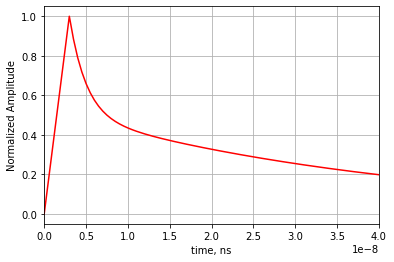

In [6]:
#plt.plot(my_sipm.template['time'], my_sipm.template['amplitude'], '.')
#plt.plot(data_template[:,0]*1.e-9 - 7e-9, data_template[:,1], '.-')
x_time = np.arange(0, 200e-9, 0.5e-9)
plt.plot(x_time, my_sipm.template['f1d'](x_time), 'r-')
plt.grid()
plt.xlabel("time, ns")
plt.ylabel("Normalized Amplitude")
plt.xlim(0, 40e-9)

No handles with labels found to put in legend.


Text(0.5, 1.0, 'FBK, NUV-HD. w/o coating')

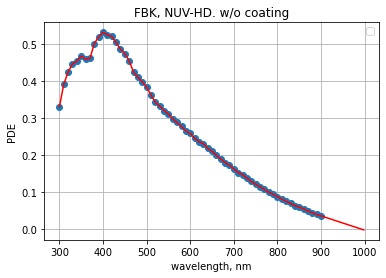

In [42]:
plt.plot(my_sipm.pde['wavelength'], my_sipm.pde['pde'], 'o')
x_wl = np.arange(300, 1000, 2)

plt.plot(x_wl, my_sipm.pde['f1d'](x_wl), '-r')

plt.grid()
plt.ylabel('PDE')
plt.xlabel('wavelength, nm')
plt.legend()
plt.title('FBK, NUV-HD. w/o coating')

### Define NSB 

In [43]:
my_nsb = NSBClass("/home/andrii/work/sipm_waveform_generator/Spectrums/Spectra_NSB_ref.txt", rate_MHz = 9.003, pe = True)

NSB :: NSB spectrum was read from file


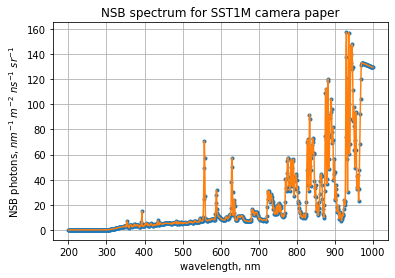

In [44]:
x_wl = np.arange(200, 1000, 1)
plt.plot(my_nsb.wavelength, my_nsb.intensity, '.')
plt.plot(x_wl, my_nsb.f1d(x_wl))
plt.ylabel('NSB photons, $nm^{-1}$ $m^{-2}$ $ns^{-1}$ $sr^{-1}$')
plt.xlabel('wavelength, nm')
plt.title('NSB spectrum for SST1M camera paper')
plt.grid()

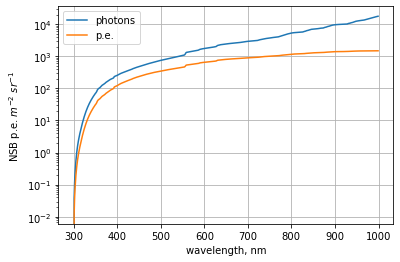

In [45]:
my_nsb.get_nsb_integrated(my_sipm.pde['f1d'])

plt.plot(my_nsb.wavelength_interpolated, my_nsb.nsb_photons_integrated, label = 'photons')
plt.plot(my_nsb.wavelength_interpolated, my_nsb.nsb_pe_integrated, label = 'p.e.')
plt.grid()
plt.yscale('log')
plt.ylabel('NSB p.e. $m^{-2}$ $sr^{-1}$')
plt.xlabel('wavelength, nm')
plt.legend()

In [46]:
aperture = 0.11
solid_angle = pow(3./930.,2)
safe_factor = 6

my_nsb.calculate_nsb_level(aperture, solid_angle, safe_factor)
my_nsb.rate_mhz = my_nsb.nsb_level_pe*1.e3

In [47]:
my_nsb.rate_mhz

10.177331771290799

### Generate Waveforms: 

In [48]:
gen_waveform = WaveformClass(my_sipm, my_shower, my_nsb, length = 1.e-6, increment = 1.e-9, baseline = 0., pe_amplitude = 5)

NSB rate 10.177331771290799 MHz
p.e. or photons True


In [49]:
gen_waveform.shower.npe

5.312289096179033

In [57]:
gen_waveform.nsb.rate_mhz = 1

In [58]:
gen_waveform.generate_waveforms(10)

waveform number :: 0
average NSB per time bin :  0.001


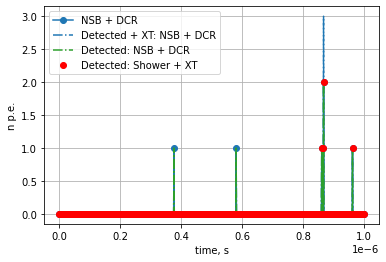

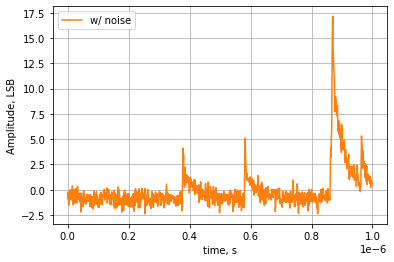

In [64]:
wf_number = 5

plt.plot(gen_waveform.time, gen_waveform.amplitude_pe_generated[wf_number], 'o-', c = 'tab:blue', label = 'NSB + DCR')
plt.plot(gen_waveform.time, gen_waveform.amplitude_pe_detected[wf_number], '-.', c = 'tab:blue', label = 'Detected + XT: NSB + DCR')
plt.plot(gen_waveform.time, gen_waveform.amplitude_pe_detected_no_xt[wf_number], '-.', c = 'tab:green', label = 'Detected: NSB + DCR')
#plt.plot(gen_waveform.time, gen_waveform.xtalk_array[wf_number], 'om')
plt.plot(gen_waveform.time, gen_waveform.amplitude_pe_shower_generated[wf_number], 'or', label = 'Detected: Shower + XT')
#plt.xlim(480e-9, 520e-9)
plt.grid()
plt.legend(loc = 2)
plt.ylabel('n p.e.')
plt.xlabel('time, s')
plt.savefig('pe.png')
plt.savefig('pe_time.png', dpi = 200)
#plt.xlim(0.49e-6,0.55e-6)
plt.show()

baseline = np.mean(gen_waveform.amplitude_lsb[wf_number])
plt.plot(gen_waveform.time, gen_waveform.amplitude_lsb[wf_number] - baseline, '-', c = 'tab:orange', label = 'w/ noise')
#plt.plot(gen_waveform.time, gen_waveform.amplitude_lsb_nonoise[wf_number], '-', label = 'w/o noise')


#plt.plot([gen_waveform.time[0], gen_waveform.time[-1]], 
#         [np.mean(gen_waveform.amplitude_lsb_nonoise[wf_number]), np.mean(gen_waveform.amplitude_lsb_nonoise[wf_number])], '-r')
#plt.plot(gen_waveform.time[::5], gen_waveform.amplitude_lsb[wf_number][::5], '.-', label = 'w/ noise, 5ns sampling')
plt.grid()
plt.ylabel('Amplitude, LSB')
plt.xlabel('time, s')
plt.legend()
#plt.xlim(0e-9, 520e-9
plt.savefig('waveform_noise.png', dpi = 200)
plt.show()

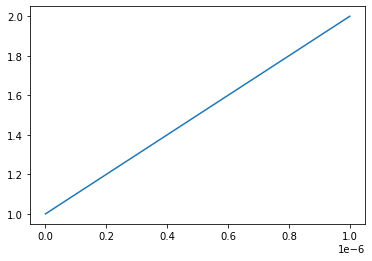

In [22]:
plt.plot([gen_waveform.time[0], gen_waveform.time[-1]], [1, 2])


In [42]:
np.sum(gen_waveform.xtalk_array)

31466.0

In [43]:
np.sum(gen_waveform.amplitude_pe_detected_no_xt)

229575.0

In [44]:
np.sum(gen_waveform.xtalk_array)/np.sum(gen_waveform.amplitude_pe_detected_no_xt)

0.13706196232168136

In [45]:
gen_waveform.shower.pe_time

array([8.64074173e-07, 8.62536365e-07, 8.59946473e-07, 8.59387360e-07,
       8.57448022e-07])

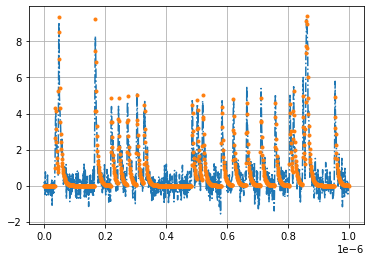

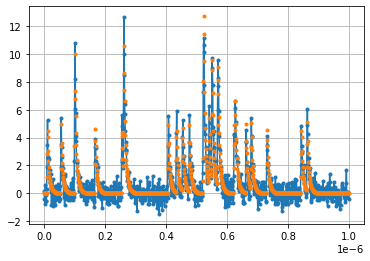

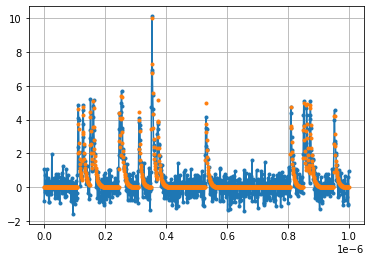

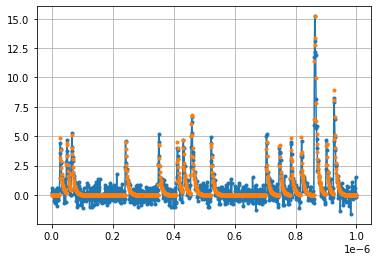

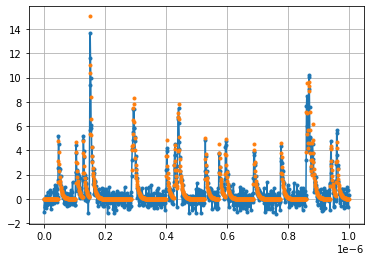

In [46]:
plt.plot(gen_waveform.time, gen_waveform.amplitude_lsb[0], '-.')
plt.plot(gen_waveform.time, gen_waveform.amplitude_lsb_nonoise[0], '.')
plt.grid()
plt.show()

plt.plot(gen_waveform.time, gen_waveform.amplitude_lsb[1], '.-')
plt.plot(gen_waveform.time, gen_waveform.amplitude_lsb_nonoise[1], '.')
plt.grid()
plt.show()

plt.plot(gen_waveform.time, gen_waveform.amplitude_lsb[2], '.-')
plt.plot(gen_waveform.time, gen_waveform.amplitude_lsb_nonoise[2], '.')
plt.grid()
plt.show()

plt.plot(gen_waveform.time, gen_waveform.amplitude_lsb[3], '.-')
plt.plot(gen_waveform.time, gen_waveform.amplitude_lsb_nonoise[3], '.')
plt.grid()
plt.show()

plt.plot(gen_waveform.time, gen_waveform.amplitude_lsb[4], '.-')
plt.plot(gen_waveform.time, gen_waveform.amplitude_lsb_nonoise[4], '.')
plt.grid()
plt.show()

In [47]:
gen_waveform.sipm.pxt

0.12

In [48]:
gen_waveform.sipm.name

'LCT5-UVE'

In [49]:
def save_data(data, name):

    try:
        file_name = name + "_waveforms_data.pickle"
        with open(file_name, "wb") as f:
            pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as ex:
        print("Error during pickling object (Possibly unsupported):", ex)

In [50]:
name = gen_waveform.sipm.name + '_px_' + str(gen_waveform.sipm.pxt)
name = '/run/media/andrii/Новый том/Terzina_sim/sim_results/' + name
name

'/run/media/andrii/Новый том/Terzina_sim/sim_results/LCT5-UVE_px_0.12'

In [51]:
save_data(gen_waveform, name)